In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.stattools import grangercausalitytests

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Date
2024-05-01    0.04571
Name: Adj Close, dtype: float64
Date
2024-08-01    0.022835
Name: Adj Close, dtype: float64


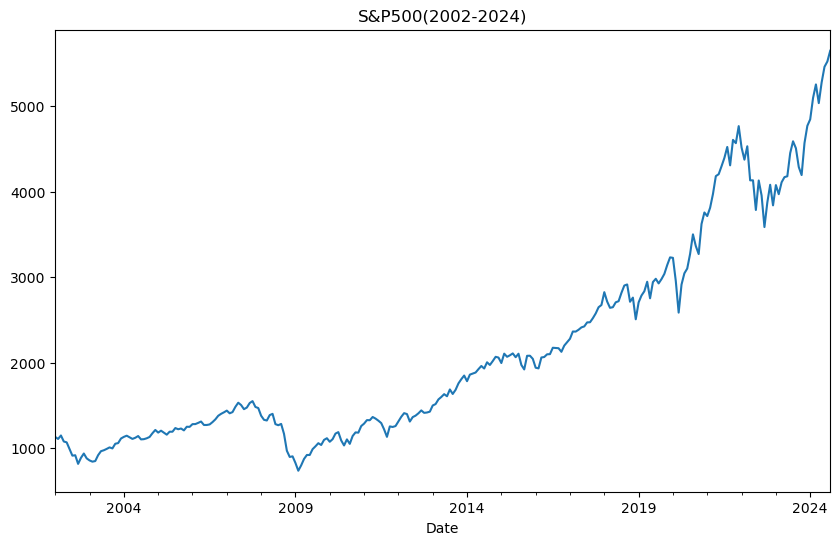

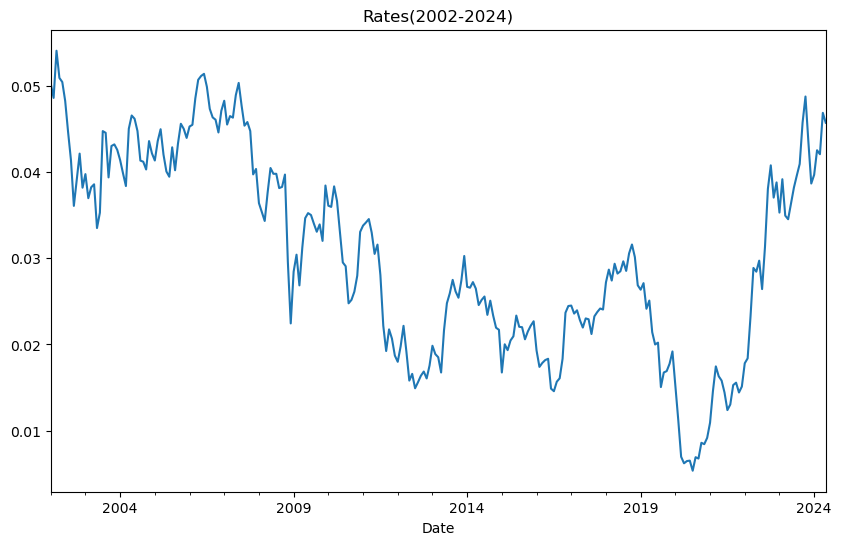

<Axes: title={'center': 'Oil(2002-2024)'}, xlabel='Date'>

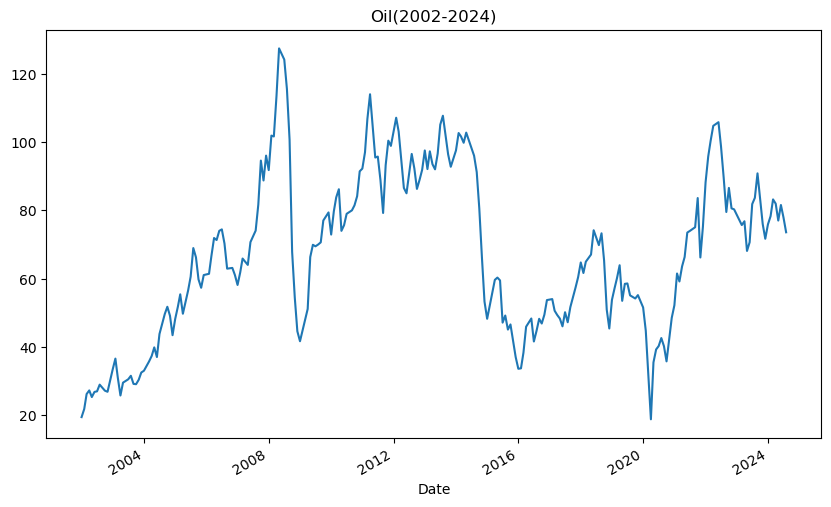

In [3]:
# Import data from yahoo finance
sp500 = yf.download('^GSPC', start='2002-01-01', end='2024-09-01', interval='1mo')['Adj Close']
rates = yf.download('^TNX', start='2002-01-01', end='2024-09-01', interval='1mo')['Adj Close']/100
oil = yf.download('CL=F', start='2002-01-01', end='2024-09-01', interval='1mo')['Adj Close']

sp500_returns = sp500.pct_change().dropna()  # Return for S&P 500 
oil_returns = oil.pct_change().dropna()      # Return for Oil

print(rates.tail(1))
print(sp500_returns.tail(1))

sp500.plot(title='S&P500(2002-2024)', figsize=(10, 6))
plt.show()
plt.close()
rates.plot(title='Rates(2002-2024)', figsize=(10, 6))
plt.show()
plt.close()
oil.plot(title='Oil(2002-2024)', figsize=(10, 6))

In [5]:
# Creation of a DataFrame 
data = pd.DataFrame({'SP500': sp500_returns, 'Rates': rates, 'Oil': oil_returns}).dropna()
# Assign frequency 
data.index = pd.date_range(start='2002-01-01', periods=len(data))

In [6]:
# Dickey-Fuller test for stationarity 
def adf_test(series, name):
    result = adfuller(series)
    print(f'ADF Statistic for {name}: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'{key}: {value}')
    if result[1] > 0.05:
        print(f'{name} is non-stationary.')
    else:
        print(f'{name} is stationary.')
    print('\n')

In [7]:
# ADF test 
adf_test(data['SP500'], 'S&P 500')
adf_test(data['Rates'], 'Interest Rates')
adf_test(data['Oil'], 'Crude Oil')

ADF Statistic for S&P 500: -5.506576231225233
p-value: 2.0155692366544914e-06
Critical Values:
1%: -3.460018927623594
5%: -2.8745897386146817
10%: -2.57372514086348
S&P 500 is stationary.


ADF Statistic for Interest Rates: -2.095389341041556
p-value: 0.24637260786583726
Critical Values:
1%: -3.4596204846395824
5%: -2.8744153028455948
10%: -2.5736320761218576
Interest Rates is non-stationary.


ADF Statistic for Crude Oil: -14.867972356537328
p-value: 1.6801458382488434e-27
Critical Values:
1%: -3.4592326027153493
5%: -2.8742454699025872
10%: -2.5735414688888465
Crude Oil is stationary.




In [9]:
# Put the series in first difference
data_diff = data.diff().dropna()

In [10]:
# Second ADF test to know if the series is stationary in first difference
adf_test(data['SP500'], 'S&P 500')
adf_test(data['Oil'], 'Crude Oil')
adf_test(data_diff['Rates'], 'Interest Rates')

ADF Statistic for S&P 500: -5.506576231225233
p-value: 2.0155692366544914e-06
Critical Values:
1%: -3.460018927623594
5%: -2.8745897386146817
10%: -2.57372514086348
S&P 500 is stationary.


ADF Statistic for Crude Oil: -14.867972356537328
p-value: 1.6801458382488434e-27
Critical Values:
1%: -3.4592326027153493
5%: -2.8742454699025872
10%: -2.5735414688888465
Crude Oil is stationary.


ADF Statistic for Interest Rates: -8.168548065870382
p-value: 8.748394584341026e-13
Critical Values:
1%: -3.4596204846395824
5%: -2.8744153028455948
10%: -2.5736320761218576
Interest Rates is stationary.




In [11]:
 # Johansen Test to test the cointegration 
def johansen_test(data):
    johan_test = coint_johansen(data, -1, 1)
    trace_stat = johan_test.lr1
    critical_values = johan_test.cvt[:, 1]  # 5% confidence level
    print('Johansen Cointegration Test')
    print('Trace Statistics:', trace_stat)
    print('Critical Values (5%):', critical_values)
    return trace_stat > critical_values

# Check series are cointegrated
print(johansen_test(data[['SP500', 'Rates', 'Oil']]))

Johansen Cointegration Test
Trace Statistics: [234.50446028 105.44233568   0.98484285]
Critical Values (5%): [24.2761 12.3212  4.1296]
[ True  True False]


In [12]:
# Vector Error Correction Model (VECM)
if johansen_test(data[['SP500', 'Rates', 'Oil']]).any():
    # Fit VECM with cointegrated variables
    vecm = VECM(data[['SP500', 'Rates', 'Oil']], k_ar_diff=1, coint_rank=1)
    vecm_fitted = vecm.fit()
    # Print VECM summary
    print(vecm_fitted.summary())
else:
    print("No cointegration detected.")

Johansen Cointegration Test
Trace Statistics: [234.50446028 105.44233568   0.98484285]
Critical Values (5%): [24.2761 12.3212  4.1296]
Det. terms outside the coint. relation & lagged endog. parameters for equation SP500
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.SP500      -0.0925      0.073     -1.269      0.204      -0.235       0.050
L1.Rates      -2.8834      1.188     -2.427      0.015      -5.212      -0.555
L1.Oil        -0.1227      0.024     -5.022      0.000      -0.171      -0.075
Det. terms outside the coint. relation & lagged endog. parameters for equation Rates
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.SP500      -0.0002      0.004     -0.057      0.954      -0.008       0.008
L1.Rates       0.0535      0.066      0.812      0.417      -0.